##  Mandy's Product Demand Project

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

label = LabelEncoder()
enc = OneHotEncoder()
scaler = StandardScaler()

So the description of the dataset is that it contains historical product demand for a manufacturing company, who manufacture different parts from different locations globally and then ship, so there is a long turn around.  The idea is - can we predict demand a month ahead to get ahead of that wait.

In [2]:
# Pull in dataset - 5  columns total

starterdataset = pd.read_csv("Historical Product Demand.csv")
starterdataset

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


In [3]:
starterdataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


In [4]:
# Check for missing data - there is a large number empty in the date field, but overall they are a smaller percentage and without the dates
# they aren't helpful in predicting the month ahead if we don't know when they took place so let's remove those rows.
nan_count = starterdataset.isna().sum()

print(nan_count)

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64


In [5]:
# Drop rows with missing values

starterdataset.dropna(inplace = True)

In [6]:
nan_count = starterdataset.isna().sum()

print(nan_count)

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64


Ok that's better.  Given the information we have and what we are looking for, when i'm thinking of features the only one I will be removing is Product Category.  The Product Code would be a subset of the category but I feel we need to know the specific code as some products within the same category might be produced in different warehouses, so for our purposes the category is not relevant

In [7]:
dataset = starterdataset.drop(["Product_Category"], axis = 1)
dataset.head(5)

,Product_Code,Warehouse,Date,Order_Demand
0,Product_0993,Whse_J,2012/7/27,100
1,Product_0979,Whse_J,2012/1/19,500
2,Product_0979,Whse_J,2012/2/3,500
3,Product_0979,Whse_J,2012/2/9,500
4,Product_0979,Whse_J,2012/3/2,500


After some testing, as this is a bit computer intense also and I want to keep my target column I might use label encoder for the target first let's check.


In [8]:
dataset.loc[:, 'Product_Code'] = label.fit_transform(dataset['Product_Code'])

dataset

,Product_Code,Warehouse,Date,Order_Demand
0,982,Whse_J,2012/7/27,100
1,968,Whse_J,2012/1/19,500
2,968,Whse_J,2012/2/3,500
3,968,Whse_J,2012/2/9,500
4,968,Whse_J,2012/3/2,500
...,...,...,...,...
1048570,1780,Whse_J,2016/4/27,1000
1048571,1962,Whse_J,2016/4/27,1
1048572,1776,Whse_J,2016/4/28,2500
1048573,890,Whse_J,2016/10/7,50


In [9]:
# Next we will need to encode - So Product Code will be our target, however there are multiple catagorical so one hot encoding.
datasettemp = pd.get_dummies(dataset[['Warehouse']], dtype=int)
datasettemp.head(5)
#Yes this worked much better

,Warehouse_Whse_A,Warehouse_Whse_C,Warehouse_Whse_J,Warehouse_Whse_S
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [10]:
# So here i keep getting Memory error, first with 7.9 g memory free, then shut a bunch of things down and tried again
# MemoryError: Unable to allocate 14.5 GiB for an array with shape (3749, 1037336) and data type int32
# I may need more ram in the end lol


In [11]:
datafull = pd.concat([dataset[['Product_Code','Date', 'Order_Demand']], datasettemp], axis=1) 
datafull.head(5)

,Product_Code,Date,Order_Demand,Warehouse_Whse_A,Warehouse_Whse_C,Warehouse_Whse_J,Warehouse_Whse_S
0,982,2012/7/27,100,0,0,1,0
1,968,2012/1/19,500,0,0,1,0
2,968,2012/2/3,500,0,0,1,0
3,968,2012/2/9,500,0,0,1,0
4,968,2012/3/2,500,0,0,1,0


ok so I think we have all our data prepared overall, there are 4 warehouses it looks like, time for some EDA, first which warehouses have how much demand in general maybe.

# So i discovered I need to do my groupby differently i'm going to do a version of this where the warehouse is label encoded so that i can bar plot the demand.


In [12]:
datasetdemand = dataset
#datasetdemand.loc[:, 'Warehouse'] = label.fit_transform(dataset['Warehouse'])

datasetdemand

,Product_Code,Warehouse,Date,Order_Demand
0,982,Whse_J,2012/7/27,100
1,968,Whse_J,2012/1/19,500
2,968,Whse_J,2012/2/3,500
3,968,Whse_J,2012/2/9,500
4,968,Whse_J,2012/3/2,500
...,...,...,...,...
1048570,1780,Whse_J,2016/4/27,1000
1048571,1962,Whse_J,2016/4/27,1
1048572,1776,Whse_J,2016/4/28,2500
1048573,890,Whse_J,2016/10/7,50


# Exploration Notes Start
In the Section below - I tried to do a sum of the Order Demand for each Warehouse but was getting errors about it not being numerical data. After doing some digging I notice that it's considered object, not int.  I tried first to convert the datatype which you'll see below just for example purposes (i'll denote below the end of this exploration section).  That did not work either.  

So next I checked the unique values within the Order_Demand column and found some values with brackets.  This lead to a discussion... are these returns to warehouse? Are the brackets errors? We aren't  sure.  Typically the answer to this would be to ask our SME/ data provider, but in the absence of being able to do that, and looking at the description that it's specifically supposed to be values of product create and sent from warehouse (with no mention of returns) we will drop the brackets and then convert to int.


In [13]:
datasetdemand.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1037336 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Product_Code  1037336 non-null  object
 1   Warehouse     1037336 non-null  object
 2   Date          1037336 non-null  object
 3   Order_Demand  1037336 non-null  object
dtypes: object(4)
memory usage: 39.6+ MB


In [14]:
dataset['Order_Demand'].unique()

array(['100 ', '500 ', '50000 ', ..., '(3750)', '(191)', '28250 '],
      dtype=object)

In [15]:
dataset['Order_Demand'] = dataset['Order_Demand'].str.replace('(', '')

dataset['Order_Demand'] = dataset['Order_Demand'].str.replace(')', '')

In [16]:
dataset['Order_Demand'].unique()
# oh look there's still an empty space so i still can't convert it grr
dataset['Order_Demand'] = dataset['Order_Demand'].str.replace(' ', '')
#dataset['Order_Demand'] = dataset['Order_Demand'].str.replace('(1)', '')


In [17]:
dataset['Order_Demand'].unique()

array(['100', '500', '50000', ..., '1700000', '497000', '28250'],
      dtype=object)

In [18]:
datasetdemand = datasetdemand.drop(["Date", "Product_Code"], axis = 1)
datasetdemand.head(5)

,Warehouse,Order_Demand
0,Whse_J,100
1,Whse_J,500
2,Whse_J,500
3,Whse_J,500
4,Whse_J,500


In [19]:
#still not working let's see how many with strings are left here
datasetdemand['Order_Demand_num'] = pd.to_numeric(datasetdemand['Order_Demand'], errors='coerce')

In [20]:
#check values of what was converted but it doesn't show any?
datasetdemand.loc[datasetdemand['Order_Demand'].notna()&datasetdemand['Order_Demand_num'].isna(), 'Order_Demand']

Series([], Name: Order_Demand, dtype: object)

In [21]:
#datasetdemand.astype('int64').dtypes
datasetdemand.astype({'Order_Demand': 'int32'}).dtypes
datasetdemand.info()
#And here we see the forced to numeric actually has the same count so strange


<class 'pandas.core.frame.DataFrame'>
Index: 1037336 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Warehouse         1037336 non-null  object
 1   Order_Demand      1037336 non-null  object
 2   Order_Demand_num  1037336 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 31.7+ MB


# Exploration End - Fix found
So this was interesting as it still didn't want to convert it! I instead had to use pd.to_numeric to get it changed and therefore need to change to that column for my bar graph.

In [22]:
df_groups = datasetdemand.groupby(['Warehouse'])['Order_Demand_num'].sum()
df_groups

Warehouse
Whse_A     147877431
Whse_C     585071404
Whse_J    3363200396
Whse_S    1038024700
Name: Order_Demand_num, dtype: int64

<class 'pandas.core.series.Series'>


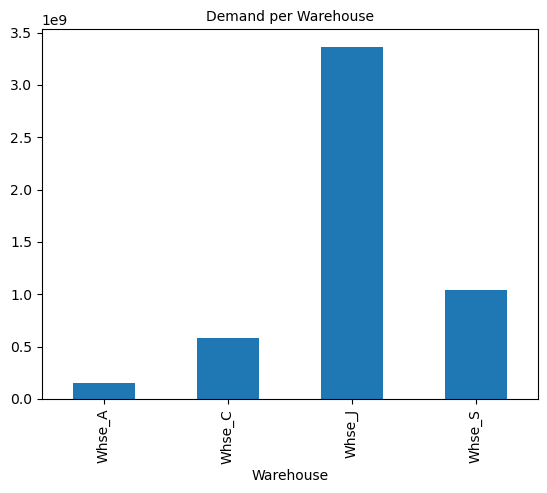

In [23]:
plt.title("Demand per Warehouse", size = 10)
#create bar plot by group
df_groups.plot(kind='bar')
print(type(df_groups))

Warehouse J seems to outproduce/ship by far with Warehouse S following at approx 1/3 of the volume of Warehouse J, so J should be the first place to optimize if possible.  Now we will go back to our datasetfull that's encoded, scale and split/train

In [24]:
datafull.head(5)

,Product_Code,Date,Order_Demand,Warehouse_Whse_A,Warehouse_Whse_C,Warehouse_Whse_J,Warehouse_Whse_S
0,982,2012/7/27,100,0,0,1,0
1,968,2012/1/19,500,0,0,1,0
2,968,2012/2/3,500,0,0,1,0
3,968,2012/2/9,500,0,0,1,0
4,968,2012/3/2,500,0,0,1,0


In [26]:
# and then train/test/split
encoded_y = datafull.iloc[:, 0].values
encoded_x = datafull.iloc[:, 1:7].values

# train is now 80% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(encoded_x, encoded_y, test_size=0.2)

print(len(X_train), len(X_test))
# test is now 10% of the initial data set
# validation is now 10% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5) 
print(len(X_train), len(X_val), len(X_test))

829868 207468
829868 103734 103734
